In [0]:



import torch
import numpy as np
import json
import random
torch.manual_seed(9)
torch.cuda.manual_seed(9)
np.random.seed(9)
random.seed(9)

torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

def evaluate(model, criterion, loader, device):
    model.eval()
    total_loss = 0.0
    num_hits = 0
    num_samples = 0

    for images, targets in loader:

        batch_size = images.size(0)
        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(False):
            logits = model(images)
            loss = criterion(logits, targets)

        _, predicted_labels = logits.max(1)
        num_hits += (targets == predicted_labels).float().sum()
        total_loss += loss * batch_size
        num_samples += batch_size

    loss = total_loss.item() / num_samples
    accuracy = num_hits.item() / num_samples
    return loss, accuracy
def make_weights_for_balanced_classes(dataset, num_classes):

    count = [0] * num_classes
    for _, label in dataset:
        count[label] += 1

    weight_per_class = [0.0] * num_classes
    N = float(sum(count))

    for i in range(num_classes):
        weight_per_class[i] = N/float(count[i])

    weights = [0.0] * len(dataset)
    for i, (_, label) in enumerate(dataset):
        weights[i] = weight_per_class[label]

    return torch.DoubleTensor(weights)


def write_logs(logs, val_logs, path):
    keys = [
        'step', 'classification_loss',
        'walker_loss', 'visit_loss'
    ]
    val_keys = [
        'val_step', 'svhn_logloss', 'svhn_accuracy',
        'mnist_logloss', 'mnist_accuracy'
    ]
    d = {k: [] for k in keys + val_keys}

    for t in logs:
        for i, k in enumerate(keys, 1):
            d[k].append(t[i])

    for t in val_logs:
        for i, k in enumerate(val_keys):
            d[k].append(t[i])

    with open(path, 'w') as f:
        json.dump(d, f)

In [0]:
import torch
import torch.nn.init
import torch.nn as nn


class Network(nn.Module):

    def __init__(self, image_size, embedding_dim):
        super(Network, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        width, height = image_size
        assert width % 8 == 0 and height % 8 == 0
        final_area = (width // 8) * (height // 8)
        self.embedding = nn.Sequential(
            nn.Linear(128 * final_area, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.final_area = final_area
        self.embedding_dim = embedding_dim

        def weights_init(m):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                torch.nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        self.apply(weights_init)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, 3, h, w].
            It represents RGB images with pixel values in [0, 1] range.
        Returns:
            a float tensor with shape [b, embedding_dim].
        """
        b = x.size(0)
        x = 2.0*x - 1.0
        x = self.feature_extractor(x)
        x = x.view(b, 128 * self.final_area)
        x = self.embedding(x).view(b, self.embedding_dim)
        return x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# a small value
EPSILON = 1e-8


class WalkerVisitLosses(nn.Module):

    def __init__(self):
        super(WalkerVisitLosses, self).__init__()

    def forward(self, a, b, labels_for_a):
        """
        Arguments:
            a: a float tensor with shape [n, d].
            b: a float tensor with shape [m, d].
            labels_for_a: a long tensor with shape [n],
                it has values in {0, 1, ..., num_labels - 1}.
        Returns:
            two float tensors with shape [].
        """
        d = a.size(1)
        p = torch.matmul(a, b.t())  # shape [n, m]
        p /= torch.tensor(d).float().sqrt()

        ab = F.softmax(p, dim=1)  # shape [n, m]
        ba = F.softmax(p.t(), dim=1)  # shape [m, n]
        aba = torch.matmul(ab, ba)  # shape [n, n]
        # note that all rows in `aba` sum to one

        labels = labels_for_a.unsqueeze(0)  # shape [1, n]
        is_same_label = (labels == labels.t()).float()  # shape [n, n]
        label_count = is_same_label.sum(1).unsqueeze(1)  # shape [n, 1]
        targets = is_same_label/label_count  # shape [n, n]
        # note that all rows in `targets` sum to one

        walker_loss = targets * torch.log(EPSILON + aba)  # shape [n, n]
        walker_loss = walker_loss.sum(1).mean(0).neg()

        visit_probability = ab.mean(0)  # shape [m]
        # note that visit_probability.sum() = 1

        m = b.size(0)
        targets = (1.0 / m) * torch.ones_like(visit_probability)
        visit_loss = targets * torch.log(EPSILON + visit_probability)  # shape [m]
        visit_loss = visit_loss.sum(0).neg()

        return walker_loss, visit_loss

In [0]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, SVHN
import numpy as np
from PIL import Image


def get_datasets(is_training):
    """
    Arguments:
        is_training: a boolean.
    Returns:
        two datasets with RGB images of size 32x32,
        pixel values are in range [0, 1].
        Possible labels are {0, 1, 2, ..., 9}.
    """
    svhn = SVHN(
        'datasets/svhn/', split='train' if is_training else 'test',
        download=True, transform=transforms.ToTensor()
    )
    mnist_transform = transforms.Compose([
        # randomly color digit and background:
        transforms.Lambda(to_random_rgb),
        transforms.Resize(32),
        transforms.ToTensor(),
    ])
    mnist = MNIST(
        'datasets/mnist/', train=is_training,
        download=True, transform=mnist_transform
    )
    return svhn, mnist


def to_random_rgb(x):
    color1 = np.random.randint(0, 256, size=3, dtype='uint8')
    color2 = np.random.randint(0, 256, size=3, dtype='uint8')
    x = np.array(x)
    x = x.astype('float32')/255.0
    x = np.expand_dims(x, 2)
    x = (1.0 - x) * color1 + x * color2
    return Image.fromarray(x.astype('uint8'))

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import math


In [0]:
import os
os.makedirs("./models", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

BATCH_SIZE = 200
NUM_EPOCHS = 15
EMBEDDING_DIM = 64

DELAY = 1000  # number of steps before turning on additional losses
GROWTH_STEPS = 1000  # number of steps of linear growth of additional losses
# so domain adaptation losses are in full strength after `DELAY + GROWTH_STEPS` steps

BETA1, BETA2 = 1.0, 0.5
DEVICE = torch.device('cuda:0')
SAVE_PATH = 'models/svhn_source'
LOGS_PATH = 'logs/svhn_source.json'


In [0]:
svhn, mnist = get_datasets(is_training=True)
source_dataset = svhn
target_dataset = mnist

weights = make_weights_for_balanced_classes(source_dataset, num_classes=10)
sampler = WeightedRandomSampler(weights, len(weights))
source_loader = DataLoader(source_dataset, BATCH_SIZE, sampler=sampler, pin_memory=True, drop_last=True)
target_loader = DataLoader(target_dataset, BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)

val_svhn, val_mnist = get_datasets(is_training=False)
val_svhn_loader = DataLoader(val_svhn, BATCH_SIZE, shuffle=False, drop_last=False)
val_mnist_loader = DataLoader(val_mnist, BATCH_SIZE, shuffle=False, drop_last=False)
print('\nsource dataset is', SOURCE_DATA, '\n')


Using downloaded and verified file: datasets/svhn/train_32x32.mat
Using downloaded and verified file: datasets/svhn/test_32x32.mat

source dataset is svhn 



In [0]:

num_steps_per_epoch = math.floor(min(len(svhn), len(mnist)) / BATCH_SIZE)
embedder = Network(image_size=(32, 32), embedding_dim=EMBEDDING_DIM).to(DEVICE)
classifier = nn.Linear(EMBEDDING_DIM, 10).to(DEVICE)
model = nn.Sequential(embedder, classifier)
model.train()


Sequential(
  (0): Network(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.1)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.1)
      (13):

In [0]:
# train_result = evaluate(model, cross_entropy, source_loader, DEVICE)
# result1 = evaluate(model, cross_entropy, val_svhn_loader, DEVICE)
# result2 = evaluate(model, cross_entropy, val_mnist_loader, DEVICE)
# interation_accuracy_on_svhn_train.insert(0, train_result[1])
# interation_accuracy_on_svhn_test.insert(0, result1[1])
# interation_accuracy_on_mnist_test.insert(0, result2[1])

In [0]:

optimizer = optim.Adam(lr=1e-3, params=model.parameters(), weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_steps_per_epoch * NUM_EPOCHS - DELAY, eta_min=1e-6)

cross_entropy = nn.CrossEntropyLoss()
association = WalkerVisitLosses()


In [0]:
def test( model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    return correct / len(test_loader.dataset)

In [0]:

text = 'e:{0:2d}, i:{1:3d}, classification loss: {2:.3f}, ' +\
    'walker loss: {3:.3f}, visit loss: {4:.4f}, ' +\
    'total loss: {5:.3f}, lr: {6:.6f}'
logs, val_logs = [], []
i = 0  # iteration
print_log = 20
interation_accuracy_on_svhn_train = []
interation_accuracy_on_svhn_test = []
interation_accuracy_on_mnist_test = []
for e in range(NUM_EPOCHS):
    model.train()
    # interation_accuracy_on_svhn_train.append(test(model, source_loader))
    # interation_accuracy_on_svhn_test.append(test(model, val_svhn_loader))
    # interation_accuracy_on_mnist_test.append(test(model, val_mnist_loader))
    counter = 0 
    for (x_source, y_source), (x_target, _) in zip(source_loader, target_loader):
        
        x_source = x_source.to(DEVICE)
        x_target = x_target.to(DEVICE)
        y_source = y_source.to(DEVICE)

        x = torch.cat([x_source, x_target], dim=0)
        embeddings = embedder(x)
        a, b = torch.split(embeddings, BATCH_SIZE, dim=0)
        logits = classifier(a)
        usual_loss = cross_entropy(logits, y_source)
        walker_loss, visit_loss = association(a, b, y_source)

        if i > DELAY:
            growth = torch.clamp(torch.tensor((i - DELAY)/GROWTH_STEPS).to(DEVICE), 0.0, 1.0)
            loss = usual_loss + growth * (BETA1 * walker_loss + BETA2 * visit_loss)
        else:
            loss = usual_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i > DELAY:
            scheduler.step()
        lr = scheduler.get_lr()[0]

        log = (e, i, usual_loss.item(), walker_loss.item(), visit_loss.item(), loss.item(), lr)
        if counter%print_log ==0:
          print(text.format(*log))
        counter +=1
        logs.append(log)
        i += 1
    
    train_result = evaluate(model, cross_entropy, source_loader, DEVICE)
    result1 = evaluate(model, cross_entropy, val_svhn_loader, DEVICE)
    result2 = evaluate(model, cross_entropy, val_mnist_loader, DEVICE)
    interation_accuracy_on_svhn_train.append(train_result[1])
    interation_accuracy_on_svhn_test.append(result1[1])
    interation_accuracy_on_mnist_test.append(result2[1])
  
    print('\nsvhn loss {0:.3f} and accuracy {1:.3f}'.format(*result1))
    print('mnist loss {0:.3f} and accuracy {1:.3f}\n'.format(*result2))
    val_logs.append((i,) + result1 + result2)
    

torch.save(model.state_dict(), SAVE_PATH)
write_logs(logs, val_logs, LOGS_PATH)

e: 0, i:  0, classification loss: 2.443, walker loss: 5.628, visit loss: 5.3258, total loss: 2.443, lr: 0.001000
e: 0, i: 20, classification loss: 1.872, walker loss: 5.477, visit loss: 5.4934, total loss: 1.872, lr: 0.001000
e: 0, i: 40, classification loss: 1.036, walker loss: 5.215, visit loss: 5.6733, total loss: 1.036, lr: 0.001000
e: 0, i: 60, classification loss: 0.688, walker loss: 5.194, visit loss: 5.7724, total loss: 0.688, lr: 0.001000
e: 0, i: 80, classification loss: 0.603, walker loss: 5.238, visit loss: 5.7383, total loss: 0.603, lr: 0.001000
e: 0, i:100, classification loss: 0.482, walker loss: 4.952, visit loss: 5.8390, total loss: 0.482, lr: 0.001000
e: 0, i:120, classification loss: 0.382, walker loss: 5.014, visit loss: 6.2038, total loss: 0.382, lr: 0.001000
e: 0, i:140, classification loss: 0.329, walker loss: 4.753, visit loss: 5.9231, total loss: 0.329, lr: 0.001000
e: 0, i:160, classification loss: 0.436, walker loss: 4.991, visit loss: 5.9703, total loss: 0.4

In [0]:
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

Sequential(
  (0): Network(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.1)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.1)
      (13):

In [0]:
test(model, val_mnist_loader)


Test set: Average loss: -7.8750, Accuracy: 9847/10000 (98.47%)



In [0]:
test(model, source_loader)


Test set: Average loss: -7.2968, Accuracy: 72931/73257 (99.55%)



In [0]:
test(model, val_svhn_loader)



Test set: Average loss: -6.6563, Accuracy: 24862/26032 (95.51%)



In [0]:
text = 'e:{0:2d}, i:{1:3d}, classification loss: {2:.3f}, ' +\
    'walker loss: {3:.3f}, visit loss: {4:.4f}, ' +\
    'total loss: {5:.3f}, lr: {6:.6f}'

In [0]:
training_loss = []
for log in logs:
  training_loss.append(log[2])

In [0]:
import matplotlib.pyplot as plt

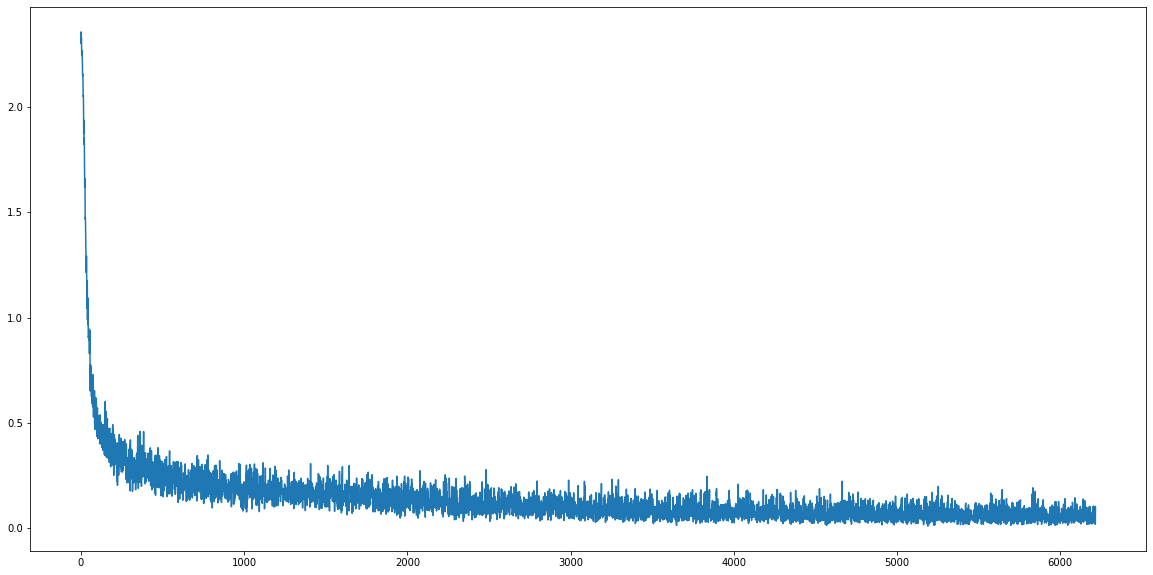

In [0]:
plt.figure(figsize=(20,10))
plt.plot(training_loss)
plt.show()

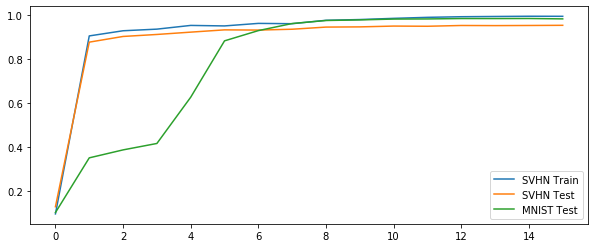

In [0]:
# .append(train_result[1])
#     interation_accuracy_on_svhn_test.append(result1[1])
#     interation_accuracy_on_mnist_test.append(result2[1])
plt.figure(figsize=(10,4))
plt.plot(interation_accuracy_on_svhn_train)
plt.plot(interation_accuracy_on_svhn_test)
plt.plot(interation_accuracy_on_mnist_test)
plt.legend(['SVHN Train', 'SVHN Test', "MNIST Test"])
plt.show()

In [0]:
embaddings = []
labels = []
for (x_source, y_source), (x_target, y_tar) in zip(source_loader, target_loader):
  y_source = y_source.data.numpy()
  y_tar = y_tar.data.numpy()
  source_embaddings = embedder(x_source.cuda())
  for i in range(source_embaddings.shape[0]):
      embaddings.append(list(source_embaddings[i].cpu().data.numpy()))
      labels.append(y_source[i])
  target_embaddings = embedder(x_target.cuda())

  for i in range(target_embaddings.shape[0]):
      embaddings.append(list(target_embaddings[i].cpu().data.numpy()))
      labels.append(y_tar[i])

# for x_target, y_tar in val_mnist_loader:
#   y_tar = y_tar.data.numpy()
#   target_embaddings = embedder(x_target.cuda())
#   for i in range(target_embaddings.shape[0]):
#     embaddings.append(list(target_embaddings[i].cpu().data.numpy()))
#     labels.append(y_tar[i])

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embaddings_2d = pca.fit_transform(embaddings)

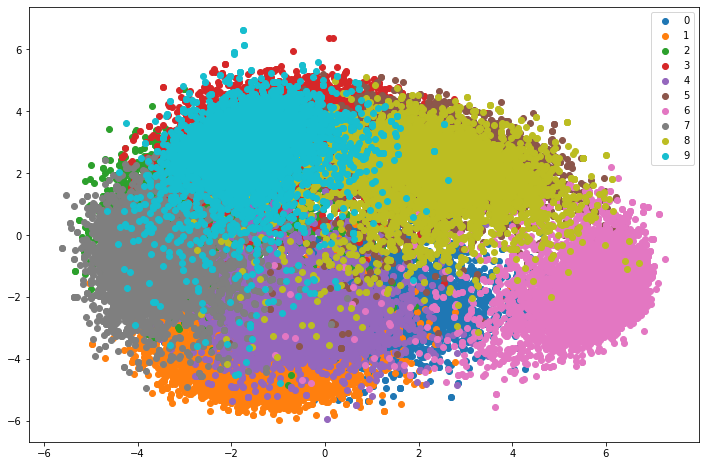

In [0]:
import pylab
pylab.figure(figsize=(12,8))
for label in list(set(labels)):
  temp_labels = []
  temp_embaddings_2d = []
  for index in range(len(labels)):
    if labels[index]==label:
      temp_labels.append(labels[index])
      temp_embaddings_2d.append(embaddings_2d[index])
  # 
  pylab.scatter(np.array(temp_embaddings_2d)[:, 0],
                np.array(temp_embaddings_2d)[:, 1])

pylab.legend(list(set(labels)))
pylab.show()

# pylab.scatter(embaddings_2d[:, 0], embaddings_2d[:, 1], c=labels)
# pylab.legend(list(set(labels)))
# pylab.show()
